<a href="https://colab.research.google.com/github/jogabenn/Advanced-Machine-Learning-Methods-Activities/blob/main/Activity3b/TC5033_Activity3b_ID4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

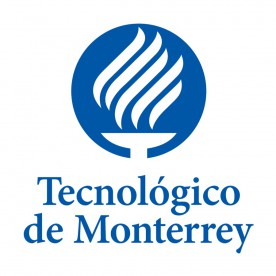

# **Masters in Applied Artificial Intelligence**
### **Course TC5033: Advanced Machine Learning Methods**
#### Tecnológico de Monterrey
#### José Antonio Cantoral Ceballos, Ph.D.<br><br>

**Group 4:**

- **Victor Alejandro Regueira Romero | A01794404 ​**
- **Fernando Maytorena Espinosa de los Monteros | A01110946​**
- **Alejandra Ramírez Romano | A01793144**
- **Jonathan Garza Bennet | A01793038​**<br><br>  


## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [ ]:
#Not required

# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [166]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others

#Install scikit-plot
#!pip install scikit-plot
#import scikitplot as skplt
#import gc

In [1]:
#Portalocker required for loading the AG_NEWS dataset
#Environment needs to be reset after this to get it working
!pip install portalocker

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
#Get AG_NEWS train and test datasets
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

#Function to tokenize dataset
def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
#test tokens
tokens = tokeniser('Welcome to TC5033')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc5033'] [3314, 4, 0]


In [8]:
#Calculate train and validation datasets sizes
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
#Split randomly into train and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
#Print the lenght of all partitions
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [12]:
#Define labels, max tokens to use and batch size
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [13]:
#Create train, validation and test loaders using truncating documents to max_tokens and with BATCH_SIZE batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [14]:
#Model hyperparameters
EMBEDDING_SIZE = 50 # 50 lenght sentences by 50 lengnt embedded word vectors to be similar to square images
NEURONS = 128 # complete
LAYERS = 2 # complete
NUM_CLASSES = len(labels) # complete

In [16]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        #LSTM chosen to avoid vanishing gradient issues on long sentences and for better context understanding
        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first = True) # Batch first required to match the Tensor dimensions
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()

        self.fc = nn.Linear(hidden, NUM_CLASSES) # complete output classifier layer using linear layer

        self.relu = nn.ReLU()


        # implement forward pass. This function will be called when executing the model
    def forward(self, x):

        #Do word embeddings based on the dictionary for the current document
        out = self.embedding_layer(x.to(torch.int64))

        #Apply LSTM and only keep the last hidden state vector output.
        out, (lstm_hidden, lsmt_cell) = self.rnn(out)

         #Only interested on the last time step output
        out = lstm_hidden[-1,:,:]

        #Apply fully connected model
        out = self.fc(out)

        #Apply ReLU
        out = self.relu(out)

        #print(len(lstm_hidden[0]))
        #print(out)

        return out

In [17]:
#Function tu calculate dataloader accuracy
def accuracy(model, loader):
    #Initialize model metrics to 0
    num_correct = 0
    num_total = 0

    #Put model in evaluation mode (no gradients, no dropout)
    model.eval()

    #Assign model to current processing device
    model = model.to(device=device)

    #We do not need gradients while doing predictions
    with torch.no_grad():

        #Loop for evaluating the model for each minibatch
        for xi, yi in loader:

            #Assign current batch of data to the assigned processing unit with correct data type
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)

            #Calculate scores and cost of current minibatch
            scores = model(xi)
            _, pred = scores.max(dim=1)

            #Accumulate the total correct and total elements evaluated
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        acc = float(num_correct)/num_total
        #Return accuracy
        return acc

In [18]:
#Function for training the model
def train(model, optimiser, epochs=100):
    #Assign model to current processing device
    model = model.to(device=device)

    #Epoch loop
    for epoch in range(epochs):

        #Loop for training the model on each of the minibatches created
        for i, (xi, yi) in enumerate(train_loader):

            #print(len(xi))
            #print(len(yi))

            #Put model on training mode (enable gradients and dropouts)
            model.train()

            #Assign current batch of data to the assigned processing unit with correct data type
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            #Calculate prediction scores
            scores = model(xi)

            #print(scores)

            #Calculate the cost
            cost = F.cross_entropy(input= scores, target=yi)

            #Reset gradients
            optimiser.zero_grad()

            #Calculate gradients
            cost.backward()

            #Update training parameters
            optimiser.step()

        #Calculate accuracy on the validation partition
        acc_train = accuracy(model, val_loader)
        acc_val = accuracy(model, train_loader)

        #Return results
        print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy_train: {acc_train}, accuracy_val: {acc_val}')

In [19]:
epochs = 10 # 10 epochs have shown to be enough for converging to good accuracy

lr = 0.001 # learning rate

# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)

#Adam optimizer for faster convergence
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


In [20]:
#Train the model and display results
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch: 0, cost: 0.7349066734313965, accuracy_train: 0.7491666666666666, accuracy_val: 0.7621574074074075
Epoch: 1, cost: 0.4022500216960907, accuracy_train: 0.8461666666666666, accuracy_val: 0.8651018518518518
Epoch: 2, cost: 0.3780108094215393, accuracy_train: 0.8796666666666667, accuracy_val: 0.9052592592592592
Epoch: 3, cost: 0.22515380382537842, accuracy_train: 0.8831666666666667, accuracy_val: 0.9154537037037037
Epoch: 4, cost: 0.24157606065273285, accuracy_train: 0.89525, accuracy_val: 0.9308333333333333
Epoch: 5, cost: 0.24523863196372986, accuracy_train: 0.8975, accuracy_val: 0.9450185185185185
Epoch: 6, cost: 0.23235101997852325, accuracy_train: 0.8966666666666666, accuracy_val: 0.9517962962962963
Epoch: 7, cost: 0.1420845240354538, accuracy_train: 0.90025, accuracy_val: 0.9573333333333334
Epoch: 8, cost: 0.1295163333415985, accuracy_train: 0.9046666666666666, accuracy_val: 0.9683703703703703
Epoch: 9, cost: 0.1300598829984665, accuracy_train: 0.8983333333333333, accuracy_val:

In [21]:
#Calculate and print test partition accuracy
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9007


In [144]:
#Function to look for a random document in a data loader, display the text, the real and the predicted labels
def sample_text(model, loader):

    #Get a random index within the data loader length
    idx = np.random.randint(len(loader.dataset))

    #Extract text and label
    y_data, x_text = loader.dataset[idx]

    #Tokenize the document
    x_tokens = tokeniser(x_text)

    #Transform tokens to vocabulary indexes
    x_vocab = vocab(x_tokens)

    #Make input to be of length max_tokens and transform to pytorch tensor
    x_vocab_max_tokens = [x_vocab + ([0]*(max_tokens - len(x_vocab))) if len(x_vocab) < max_tokens else x_vocab[:max_tokens]]
    x_vocab_max_tokens = torch.tensor(x_vocab_max_tokens, dtype=torch.int32)

    #Calculate model scores
    scores = model(x_vocab_max_tokens)

    #Display results
    print('Document Text is:\n\n{}'.format(x_text))
    print('\nReal Document Label is: {}'.format(labels[y_data-1]))
    print('\nPredicted Document Label is: {}'.format(labels[int(torch.max(scores,1)[1][0])]))

In [165]:
#Test model with random documents from test_loader
sample_text(rnn_model, test_loader)

Document Text is:

Astronomers Spot Monster Collision of Galaxies (Reuters) Reuters - If you think Earth is a mess,\consider the turmoil in the constellation Hydra, where\astronomers have spotted two monster galactic clusters slamming\together in one of the biggest collisions ever recorded.

Real Document Label is: Sci/Tech

Predicted Document Label is: Sci/Tech


In [22]:
#Import required modules for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to create and plot a confusion matrix
def plot_confusion_matrix(labels, predictions, class_names):
    """
    Plot a confusion matrix using seaborn.

    Args:
    - labels (array): Array of true class labels.
    - predictions (array): Array of predicted class labels.
    - class_names (list): List containing names of classes.
    """
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [28]:
#Function to evaluate the model against a data partition
def evaluate_model(model, loader):
    """
    Evaluate the model on accuracy, loss, and other metrics.

    Args:
    - model (torch.nn.Module): The model to be evaluated.
    - loader (torch.utils.data.DataLoader): DataLoader for the evaluation dataset.

    Returns:
    - dict: A dictionary containing various performance metrics.
    """
    #Evaluate the model and create lists with the results
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []
    total_loss = 0

    #For improved efficiencies, no gradient calculation required for model predictions
    with torch.no_grad():

        #Calculate the model metrics against the selected test partition for all batches
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            #loss = F.cross_entropy(outputs, y)
            #total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    #Store results
    #avg_loss = total_loss / len(loader)
    acc = accuracy(model, loader)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    class_report = classification_report(all_labels, all_preds, target_names=labels, output_dict=True)

    #Create a dictionary with the final metrics
    metrics = {
        #'loss': avg_loss,
        'accuracy': acc,
        'classification_report': class_report,
    }
    return metrics, all_labels, all_preds

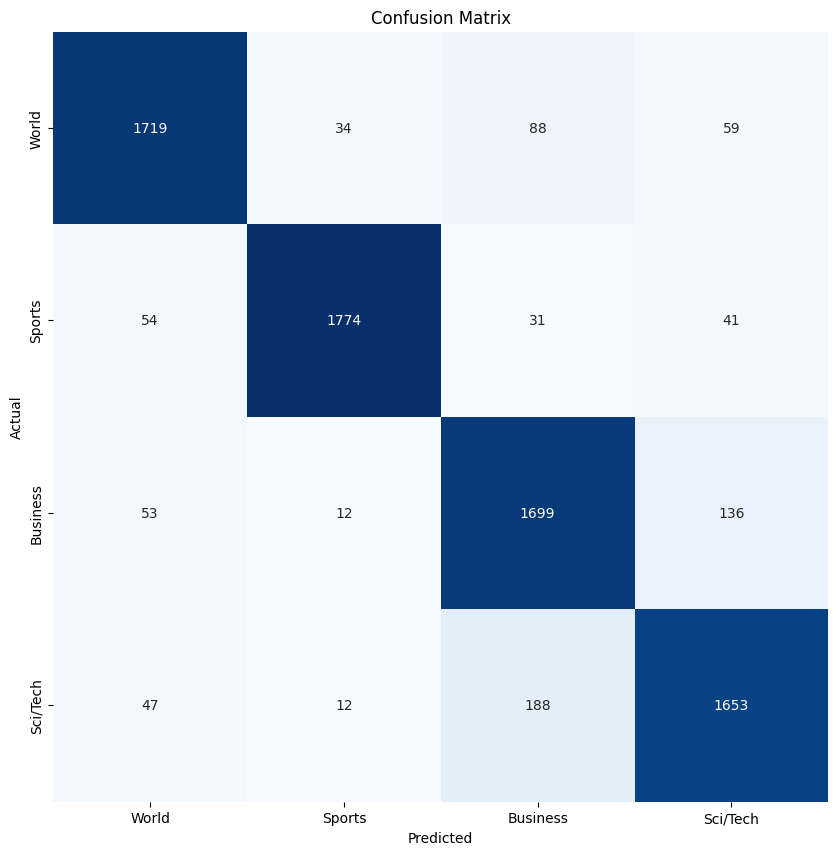

In [29]:
# Evaluate the model
metrics, all_labels, all_preds = evaluate_model(rnn_model, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds, labels)

### **Conclusions**

***With this text document classification excercise using the AG News data set, it was possible to study and understand the power of word embedding used in parallel with recurrent neural networks for analysing time-based data series. On this case, all the text documents were tokenized and then translated to an index summary using the torch text basic english dictionary. After transforming the text time series into numerical data, then word embeddings were created using the dictionary length and the same maximum vector dimensions to create square shaped tensors as input for our model. LSTM was chosen as the recurrent neural network model due to its capabilty for reducing the vanishing gradient issues for long input tensors and for its improved capabilty on holding the context for the time series being analyzed. The accuracy results achieved for all test partitions were equal to 90% or higher, so a very good abstraction from the word embedding tensors was reached. RNNs are a very powerful tool for modeling any data type that could be described as a time or sequence series.***

******